In [ ]:
# hide
# dont_test
%load_ext nb_black

%config InlineBackend.figure_format="retina"

<IPython.core.display.Javascript object>

# Test Downloads

## Create Files

In [ ]:
# dont_test

import os
import hashlib
import requests

import pandas as pd

from pathlib import Path
from datetime import datetime
from urllib.parse import urljoin

<IPython.core.display.Javascript object>

In [ ]:
# dont_test
project_root = Path.cwd() / ".."
data_root = project_root / "example" / "data"
data_root.mkdir(exist_ok=True)

<IPython.core.display.Javascript object>

In [ ]:
%%time
# dont_test
file_size = 1024 * 1024 * 10
num_to_md5sum = {}
for num in range(100):
    file_path = data_root / str(num)
    if file_path.exists():
        with file_path.open("rb") as f:
            data = f.read()
    else:
        with file_path.open("wb") as f:
            data = os.urandom(file_size)
            f.write(data)
    num_to_md5sum[num] = hashlib.md5(data).hexdigest()

CPU times: user 1.49 s, sys: 264 ms, total: 1.75 s
Wall time: 1.93 s


<IPython.core.display.Javascript object>

## Plotting Helper

In [ ]:
# dont_test


def df_from_timestamps(timestamps, file_size):
    min_started = min([started for started, stopped in timestamps])
    max_stopped = max([stopped for started, stopped in timestamps])
    index = pd.date_range(start=min_started, end=max_stopped, freq="ms")
    df = pd.DataFrame(index=index)
    for i, ts in enumerate(timestamps):
        start, end = ts
        duration = (end - start).total_seconds()
        bandwidth = (file_size / duration) / 10 ** 6
        column = f"client_{i}"
        df.loc[:, column] = 0
        df.loc[start:end, column] = bandwidth
    return df


def plot_download_df(df):
    ax = df.plot(figsize=(10, 6), legend=False, title="Bandwidth used by clients")
    ax.set_xlabel("Time")
    _ = ax.set_ylabel("MB/s")

<IPython.core.display.Javascript object>

## Download Synchronously

Start server with:
```shell
cd example
python manage.py runserver 0.0.0.0:8000
```

In [ ]:
# dont_test
timestamps = []
base_url = "http://localhost:8000"
for num, expected_md5sum in num_to_md5sum.items():
    url = urljoin(base_url, f"{num}")
    started = datetime.now()
    r = requests.get(url)
    stopped = datetime.now()
    timestamps.append((started, stopped))
    r.raise_for_status()
    actual_md5sum = hashlib.md5(r.content).hexdigest()
    assert expected_md5sum == actual_md5sum

<IPython.core.display.Javascript object>

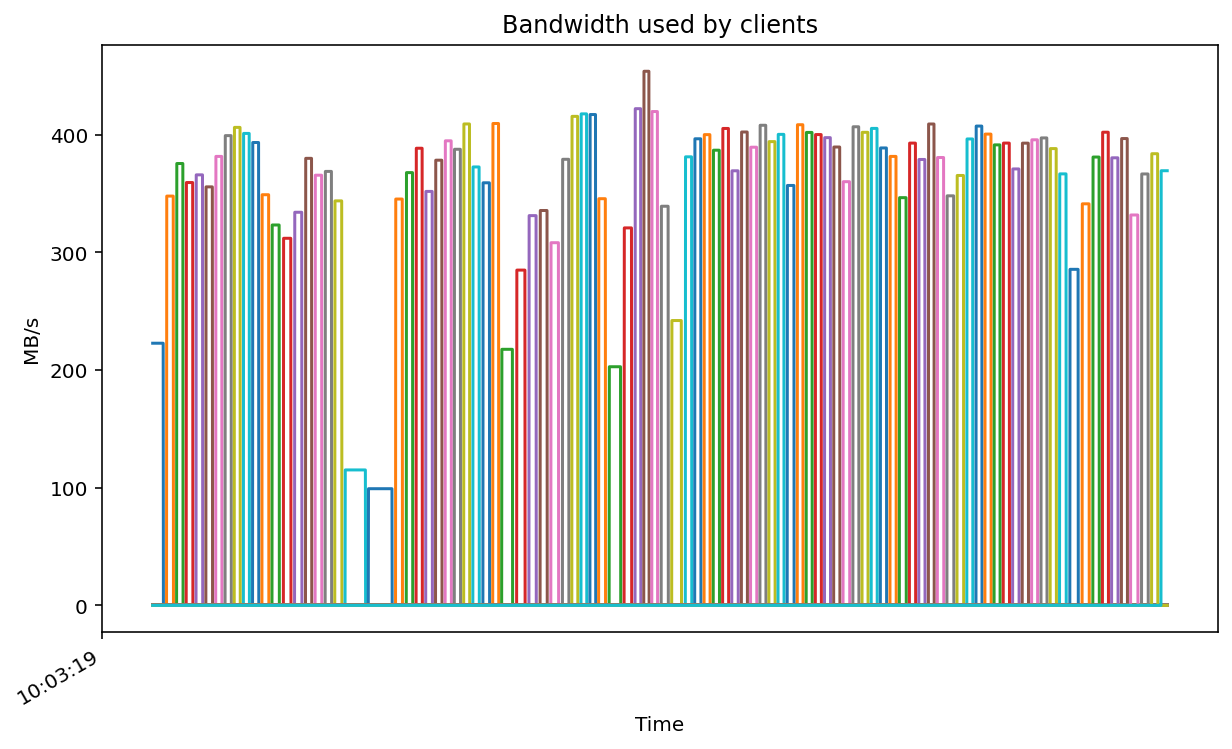

<IPython.core.display.Javascript object>

In [ ]:
# dont_test


df = df_from_timestamps(timestamps, file_size)
plot_download_df(df)

## Downloads Concurrently

Start server with:
```shell
cd example
gunicorn -w 2 -k uvicorn.workers.UvicornWorker -b :8000 "example.asgi:application"
```

In [ ]:
# dont_test

import gevent

from gevent import monkey

monkey.patch_all()


class Response:
    def __init__(self, url, content, started, stopped):
        self.url = url
        self.content = content
        self.started = started
        self.stopped = stopped


def streaming_fetch(url):
    chunks = []
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        started = datetime.now()
        for chunk in r.iter_content(chunk_size=4096):
            chunks.append(chunk)
    stopped = datetime.now()
    response = Response(url, b"".join(chunks), started, stopped)
    return response

<ipython-input-8-181895b379cf>:7: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util (/Users/jochen/.virtualenvs/django-fileresponse/lib/python3.9/site-packages/urllib3/util/__init__.py)', 'urllib3.util.ssl_ (/Users/jochen/.virtualenvs/django-fileresponse/lib/python3.9/site-packages/urllib3/util/ssl_.py)']. 
  monkey.patch_all()


<IPython.core.display.Javascript object>

In [ ]:
# dont_test

urls = []
base_url = "http://localhost:8000"
for num, expected_md5sum in num_to_md5sum.items():
    url = urljoin(base_url, f"{num}")
    urls.append(url)

jobs = [gevent.spawn(streaming_fetch, _url) for _url in urls]
responses = gevent.wait(jobs)
responses = [r.value for r in responses]

timestamps = []
for num, response in enumerate(responses):
    timestamps.append((response.started, response.stopped))
    expected_md5sum = num_to_md5sum[num]
    actual_md5sum = hashlib.md5(response.content).hexdigest()

<IPython.core.display.Javascript object>

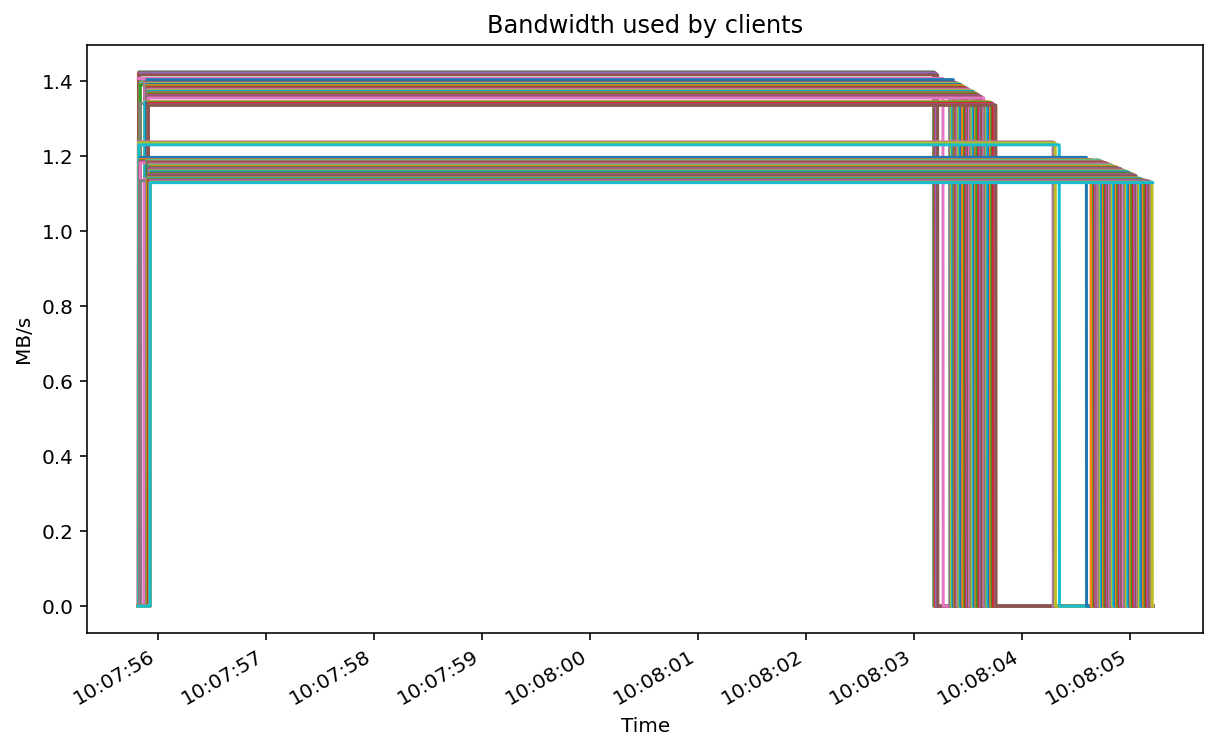

<IPython.core.display.Javascript object>

In [ ]:
# dont_test

df = df_from_timestamps(timestamps, file_size)
plot_download_df(df)